# Bayesian Regression (Stan)

This analysis focused on predictors of a country's happiness.

The data was taken from Helliwell et al. (2017) and contains data at a national level for 155 countries.

Some elements are based on Sanborn (2021), with modifications.

In [1]:
set.seed(42)

In [2]:
# loads packages

library(data.table)
library(ggplot2)
library(rstanarm)
library(bridgesampling)

Loading required package: Rcpp

This is rstanarm version 2.21.1

- See https://mc-stan.org/rstanarm/articles/priors for changes to default priors!

- Default priors may change, so it's safest to specify priors, even if equivalent to the defaults.

- For execution on a local, multicore CPU with excess RAM we recommend calling

  options(mc.cores = parallel::detectCores())



In [3]:
# sets theme for ggplot2

theme_set(theme_bw() + theme(panel.border=element_blank(), panel.grid.major=element_blank(), panel.grid.minor=element_blank(), axis.line=element_line(colour="black")))

In [4]:
# loads data set

dat_happiness<-fread("Data/Data_Happiness.csv")

## Data Visualisation

In [5]:
plt_hist_happiness<-ggplot(dat_happiness) +
  aes(x=Happiness_Score) + 
  geom_histogram(aes(y=..density..), binwidth=.2, col="black") +
  scale_y_continuous(expand=c(0,0)) +
  coord_cartesian(xlim=c(0, 10)) +
  ggtitle("Figure 1. Histogram of Happiness.") +
  labs(y="Density", x="Happiness")

The happiness score used in this analysis is an aggregated index of multiple measures and ranges from 0 to 10. The distribution of happiness is as follows:

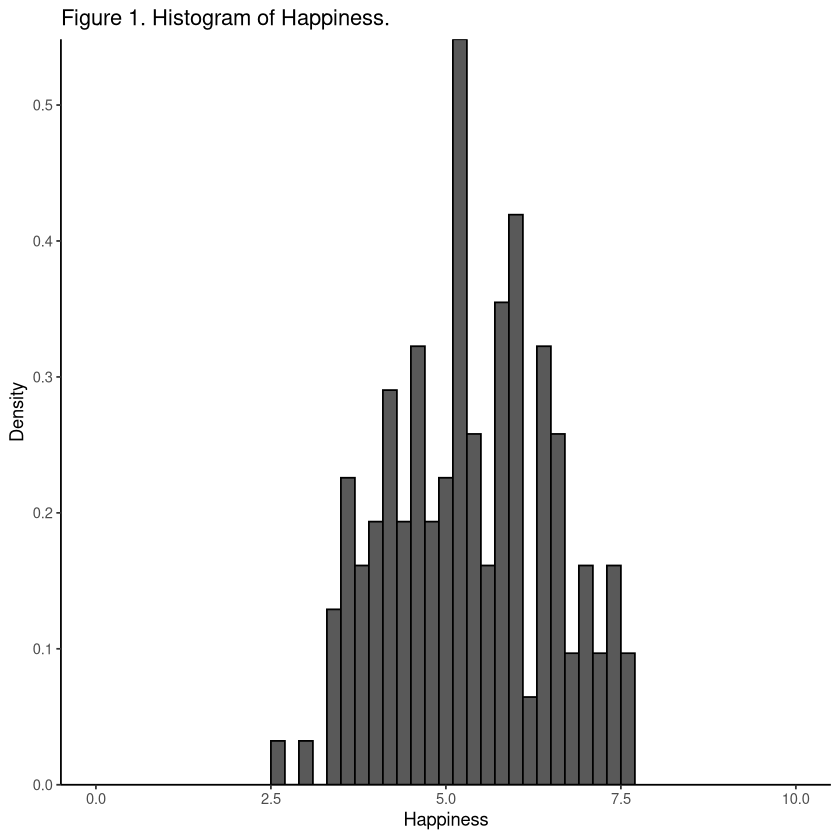

In [6]:
plt_hist_happiness

## Model 1

We first tested whether GDP per capita predicts happiness.

The model of interest is:

$$
\mathit{happiness}_i = \beta_1 + \beta_2 \mathit{GDP}_i + \varepsilon_i, \varepsilon_i \sim N(0, \sigma^2)
$$

where $\mathit{happiness}$ is the happiness score of a country and $\mathit{GDP}$ is GDP per capita. GDP per capita is an adjusted index, see Helliwell et al. (2017)  for details.

### Frequentist Model

In [7]:
lm_happiness_GDP<-lm(Happiness_Score~GDP_per_Capita, data=dat_happiness)
summary(lm_happiness_GDP)


Call:
lm(formula = Happiness_Score ~ GDP_per_Capita, data = dat_happiness)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.88806 -0.45200 -0.05328  0.49426  1.89833 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)      3.2032     0.1356   23.62   <2e-16 ***
GDP_per_Capita   2.1842     0.1267   17.24   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.6617 on 153 degrees of freedom
Multiple R-squared:  0.6601,	Adjusted R-squared:  0.6579 
F-statistic: 297.1 on 1 and 153 DF,  p-value: < 2.2e-16


Results show that GDP per capita is a significant predictor of happiness.

The 95% confidence intervals are as follows:

In [8]:
confint(lm_happiness_GDP)

,2.5 %,97.5 %
(Intercept),2.935283,3.471143
GDP_per_Capita,1.933858,2.434511


### Bayesian Model

Weakly informative priors are used for the parameters:

$$
\beta_1 \sim N(5, 3^2)
$$

$$
\beta_2 \sim N(0, 2.5^2)
$$

$$
\sigma \sim \text{Exp}(1)
$$

3 chains were run for 1000 iterations after an inital burn-in with 100 iterations.

In [9]:
stan_lm_happiness_GDP<-stan_glm(Happiness_Score~GDP_per_Capita, data=dat_happiness, refresh=0, chain=3, iter=1100, warmup=100, prior_intercept=normal(location=5, scale=3, autoscale=FALSE), prior=normal(location=0, scale=2.5, autoscale=FALSE), prior_aux=exponential(rate=1, autoscale=FALSE), diagnostic_file=file.path(tempdir(), "stan_lm_happiness_GDP.csv"))

As shown below, it is clear that the chains for all parameters had converged and are stationary.

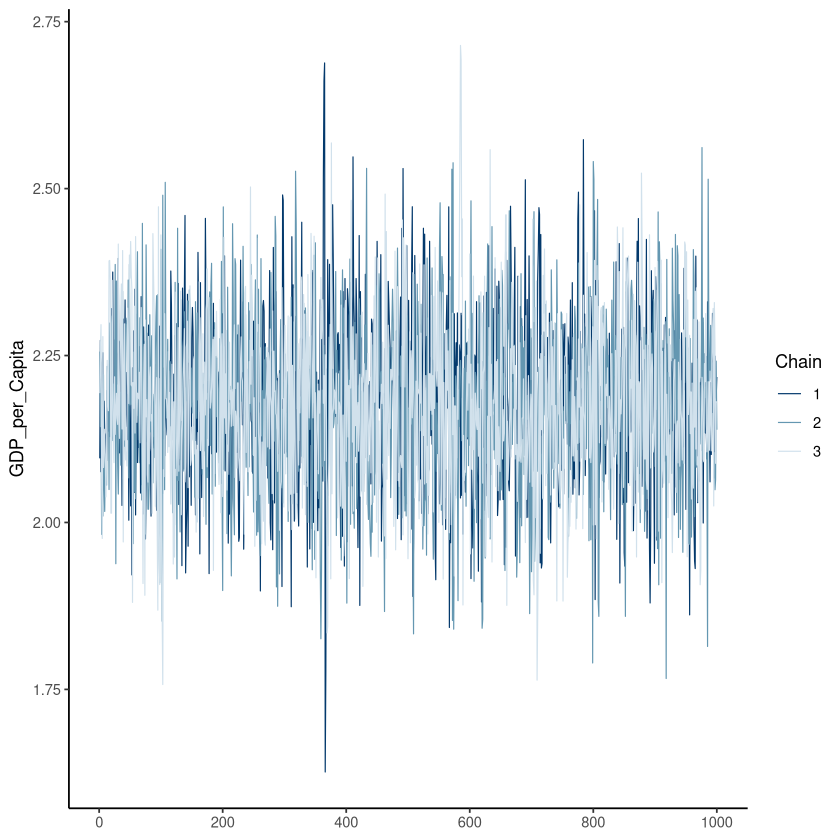

In [10]:
plot(stan_lm_happiness_GDP, plotfun="trace", par="GDP_per_Capita")

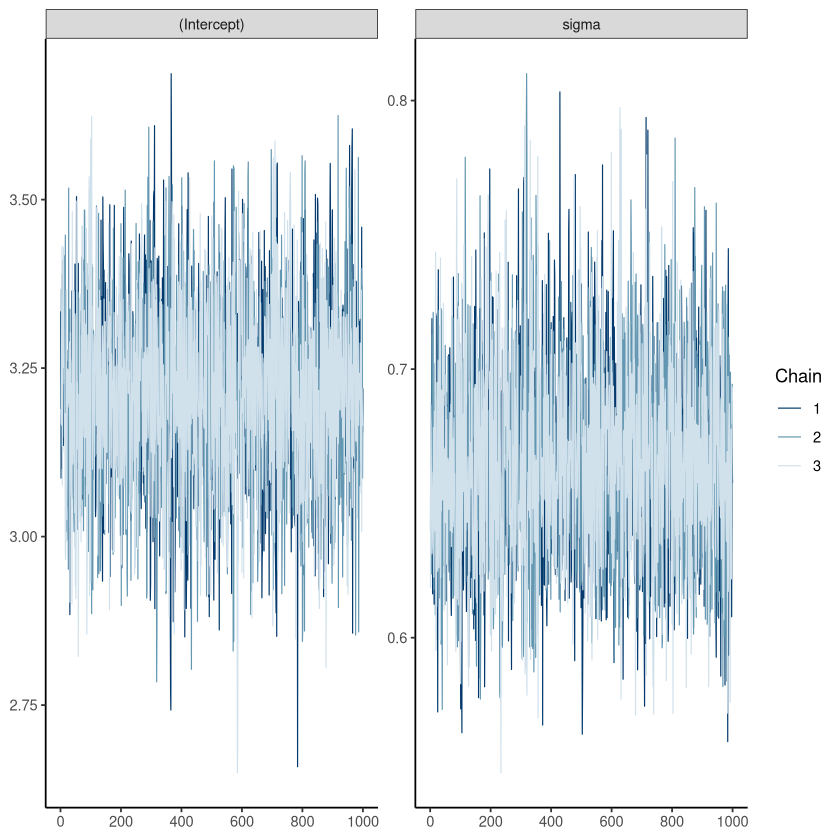

In [11]:
plot(stan_lm_happiness_GDP, plotfun="trace", par=c("(Intercept)", "sigma"))

The mean estimate of $\beta_2$ (the coefficient of GDP per capita) is 2.2 which is very close to the frequentist model.

$\hat{R}$ values confirm that the chains had converged.

In [12]:
summary(stan_lm_happiness_GDP)


Model Info:
 function:     stan_glm
 family:       gaussian [identity]
 formula:      Happiness_Score ~ GDP_per_Capita
 algorithm:    sampling
 sample:       3000 (posterior sample size)
 priors:       see help('prior_summary')
 observations: 155
 predictors:   2

Estimates:
                 mean   sd   10%   50%   90%
(Intercept)    3.2    0.1  3.0   3.2   3.4  
GDP_per_Capita 2.2    0.1  2.0   2.2   2.3  
sigma          0.7    0.0  0.6   0.7   0.7  

Fit Diagnostics:
           mean   sd   10%   50%   90%
mean_PPD 5.4    0.1  5.3   5.4   5.5  

The mean_ppd is the sample average posterior predictive distribution of the outcome variable (for details see help('summary.stanreg')).

MCMC diagnostics
               mcse Rhat n_eff
(Intercept)    0.0  1.0  2754 
GDP_per_Capita 0.0  1.0  2974 
sigma          0.0  1.0  2467 
mean_PPD       0.0  1.0  2636 
log-posterior  0.0  1.0  1154 

For each parameter, mcse is Monte Carlo standard error, n_eff is a crude measure of effective sample size

95% credible intervals are as follows which are similar to the confidence intervals of the frequentist model:

In [13]:
posterior_interval(stan_lm_happiness_GDP, prob=.95)

,2.5%,97.5%
(Intercept),2.9264118,3.4873927
GDP_per_Capita,1.9282208,2.4290722
sigma,0.5978377,0.7435478


#### Bayes Factor

In [14]:
stan_lm_happiness_intercept<-stan_glm(Happiness_Score~1, data=dat_happiness, refresh=0, chain=3, iter=1100, warmup=100, prior_intercept=normal(location=5, scale=3, autoscale=FALSE), prior_aux=exponential(rate=1, autoscale=FALSE), diagnostic_file=file.path(tempdir(), "stan_lm_happiness_intercept.csv"))

In [15]:
bridge_stan_lm_happiness_intercept<-bridge_sampler(stan_lm_happiness_intercept, silent=TRUE)
bridge_stan_lm_happiness_GDP<-bridge_sampler(stan_lm_happiness_GDP, silent=TRUE)

The dramatically large Bayes Factor shows that the model with GDP per capita as a predictor is preferred.

In [16]:
bf(bridge_stan_lm_happiness_GDP, bridge_stan_lm_happiness_intercept)

Estimated Bayes factor in favor of bridge_stan_lm_happiness_GDP over bridge_stan_lm_happiness_intercept: 39612540051419972771220191625347072.00000

### Conclusion

The frequentist model shows that GDP per capita can significantly predict happiness ($b$ = 2.18, $t$ = 17.24, $p$ < .001).

The Bayesian model shows that the mean posterior estimate is 2.2, with a 95% credible interval of [1.93, 2.42]. $\mathrm{BF}_{10} = 3.9 \times 10^{34}$ provides decisive evidence to support the model over the intercept-only model.

## Model 2

The model of interest is:

$$
\mathit{happiness}_i = \beta_1 + \beta_2 \mathit{GDP}_i + \beta_3 \mathit{LE}_i + \beta_4 \mathit{Freedom}_i + \beta_5 \mathit{Generosity}_i + \varepsilon_i, \varepsilon_i \sim N(0, \sigma^2)
$$

where $\mathit{LE}$ is life expectancy, $\mathit{Freedom}$ is the perceived freedom of a country's citizens to make life decisions, and $\mathit{Generosity}$ is generosity as measured by recent donations. All three are normalised.

### Frequentist Model

In [17]:
lm_happiness_complex<-lm(Happiness_Score~GDP_per_Capita+Life_Expectancy+Freedom+Generosity, data=dat_happiness)
summary(lm_happiness_complex)


Call:
lm(formula = Happiness_Score ~ GDP_per_Capita + Life_Expectancy + 
    Freedom + Generosity, data = dat_happiness)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.60940 -0.32723  0.03747  0.38389  1.18142 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)       2.3814     0.1538  15.487  < 2e-16 ***
GDP_per_Capita    1.2699     0.2007   6.328 2.71e-09 ***
Life_Expectancy   1.3492     0.3495   3.860 0.000168 ***
Freedom           2.0967     0.3373   6.216 4.81e-09 ***
Generosity        0.4909     0.3517   1.396 0.164788    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.5467 on 150 degrees of freedom
Multiple R-squared:  0.7725,	Adjusted R-squared:  0.7664 
F-statistic: 127.3 on 4 and 150 DF,  p-value: < 2.2e-16


Results show that GDP per capita, life expectancy, and freedom are significant predictors, but not generosity.

In [18]:
confint(lm_happiness_complex)

,2.5 %,97.5 %
(Intercept),2.0775379,2.685188
GDP_per_Capita,0.8733704,1.666352
Life_Expectancy,0.6586562,2.039812
Freedom,1.4302093,2.763241
Generosity,-0.2039498,1.185798


Adjusted $R^2$ shows that Model 2 (.77) provides better fit than Model 1 (.66).

F-statistic below also suggests that Model 2 is a better model.

In [19]:
anova(lm_happiness_GDP, lm_happiness_complex)

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,153,66.98344,NA,NA,NA,NA
2,150,44.83914,3,22.1443,24.69305,4.83287e-13


### Bayesian Model

The same weakly informative priors are used for the parameters:

$$
\beta_1 \sim N(5, 3^2)
$$

$$
\beta_k \sim N(0, 2.5^2), k = 2, ..., 5
$$

$$
\sigma \sim \text{Exp}(1)
$$

In [20]:
stan_lm_happiness_complex<-stan_glm(Happiness_Score~GDP_per_Capita+Life_Expectancy+Freedom+Generosity, data=dat_happiness, refresh=0, chain=3, iter=1100, warmup=100, prior_intercept=normal(location=5, scale=3, autoscale=FALSE), prior=normal(location=0, scale=2.5, autoscale=FALSE), prior_aux=exponential(rate=1, autoscale=FALSE), diagnostic_file=file.path(tempdir(), "stan_lm_happiness_complex.csv"))

Similarly, 3 chains were run for 1000 iterations after an inital burn-in with 100 iterations.

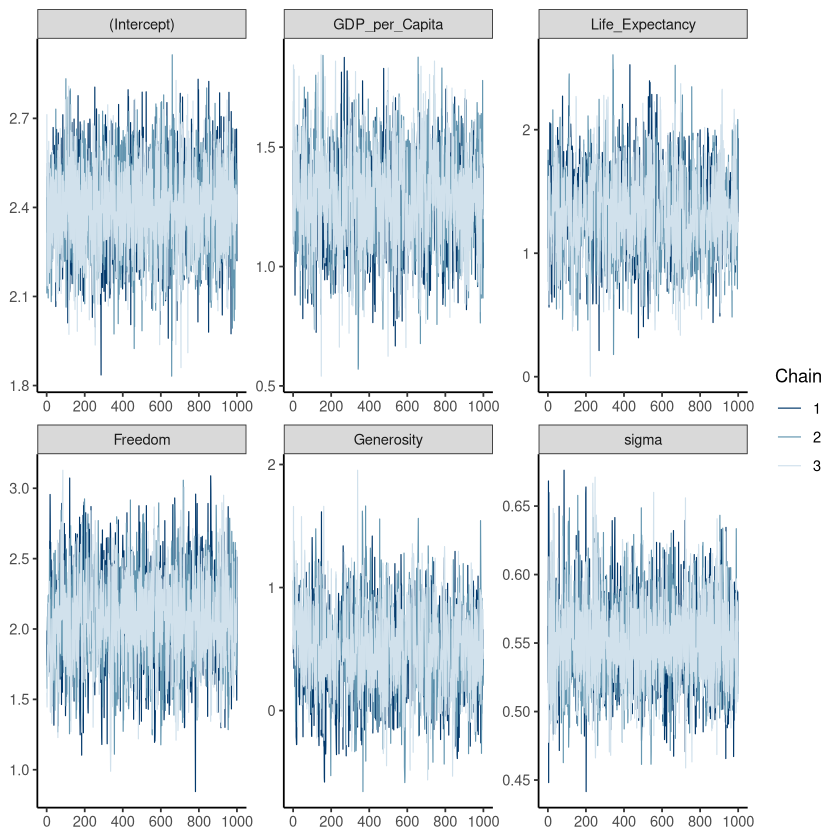

In [21]:
plot(stan_lm_happiness_complex, plotfun="trace")

In [22]:
summary(stan_lm_happiness_complex)


Model Info:
 function:     stan_glm
 family:       gaussian [identity]
 formula:      Happiness_Score ~ GDP_per_Capita + Life_Expectancy + Freedom + 
	   Generosity
 algorithm:    sampling
 sample:       3000 (posterior sample size)
 priors:       see help('prior_summary')
 observations: 155
 predictors:   5

Estimates:
                  mean   sd   10%   50%   90%
(Intercept)     2.4    0.2  2.2   2.4   2.6  
GDP_per_Capita  1.3    0.2  1.0   1.3   1.5  
Life_Expectancy 1.3    0.4  0.9   1.3   1.8  
Freedom         2.1    0.3  1.6   2.1   2.5  
Generosity      0.5    0.4  0.1   0.5   0.9  
sigma           0.6    0.0  0.5   0.5   0.6  

Fit Diagnostics:
           mean   sd   10%   50%   90%
mean_PPD 5.4    0.1  5.3   5.4   5.4  

The mean_ppd is the sample average posterior predictive distribution of the outcome variable (for details see help('summary.stanreg')).

MCMC diagnostics
                mcse Rhat n_eff
(Intercept)     0.0  1.0  2837 
GDP_per_Capita  0.0  1.0  1695 
Life_Exp

The 95% credible intervals of GDP per capita, life expectancy, and freedom do not include zero, but that of generosity does.

This is consistent with the frequentist model which shows that generosity is not significant.

In [23]:
posterior_interval(stan_lm_happiness_complex, prob=.95)

,2.5%,97.5%
(Intercept),2.0948435,2.6918757
GDP_per_Capita,0.8703992,1.6615164
Life_Expectancy,0.6371903,2.0175971
Freedom,1.3987393,2.7340238
Generosity,-0.2115669,1.1941390
sigma,0.4916618,0.6186031


The mean posterior $R^2$ is as follows:

In [24]:
mean(bayes_R2(stan_lm_happiness_complex))

[1] 0.7646081

#### Bayes Factor

In [25]:
bridge_stan_lm_happiness_complex<-bridge_sampler(stan_lm_happiness_complex, silent=TRUE)

In [26]:
bf(bridge_stan_lm_happiness_complex, bridge_stan_lm_happiness_GDP)

Estimated Bayes factor in favor of bridge_stan_lm_happiness_complex over bridge_stan_lm_happiness_GDP: 36852779533.88866

Bayes factor shows that Model 2 is preferred over Model 1.

### Conclusion

The frequentist model shows that GDP per capita ($b$ = 1.27, $t$ = 6.33, $p$ < .001), life expectancy ($b$ = 1.35, $t$ = 3.86, $p$ < .001), and freedom ($b$ = 2.10, $t$ = 6.23, $p$ < .001) can significantly predict happiness, but not generosity ($b$ = 0.49, $t$ = 1.40, $p$ = .16). Results also show that the model fits better than the model with only GDP per capita as predictor ($F$ (3, 150) = 24.69, $p$ < .001).

The Bayesian model shows that the posterior estimates of GDP per capita (mean = 1.3, 95% credible interval [0.87, 1.66]), life expectancy (mean = 1.3, 95% credible interval [0.64, 2.02], and freedom (mean = 2.1, 95% credible interval [1.40, 2.70]) do not contain zero, but generosity (mean = 0.5, 95% credible interval [-0.21, 1.19]) do. $\mathrm{BF}_{10} = 3.7 \times 10^{10}$ provides decisive evidence to support this model over the one with only GDP per capita as predictor.